In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import netCDF4 as nc
import datetime as dt
from salishsea_tools import evaltools as et, viz_tools
import gsw
import matplotlib as mpl
import cmocean as cmo
import cmocean
import f90nml
import pickle
import os
from collections import OrderedDict

fs=16
mpl.rc('xtick', labelsize=fs)
mpl.rc('ytick', labelsize=fs)
mpl.rc('legend', fontsize=fs)
mpl.rc('axes', titlesize=fs)
mpl.rc('axes', labelsize=fs)
mpl.rc('figure', titlesize=fs)
mpl.rc('font', size=fs)
mpl.rc('text', usetex=True)
mpl.rc('text.latex', preamble = r'''
 \usepackage{txfonts}
 \usepackage{lmodern}
 ''')
mpl.rc('font', family='sans-serif', weight='normal', style='normal')

import warnings
warnings.filterwarnings('ignore')
from IPython.display import Markdown, display

%matplotlib inline

In [2]:
modver = '202007C-p3'
matchpath = '/data/sallen/results/MEOPAR/202007/202007C-p3/ObsModel_202007Cp3_PUG_20150701-20151231.csv'
#datespan = '20150101-20151231'
fname = 'Cp3_WADE_20150101-20151231.csv'
start_date=dt.datetime(2015,7,6)
end_date=dt.datetime(2015,12,31)
datadir='/ocean/eolson/MEOPAR/obs/WADE/ptools_data/ecology'
year=2015

In [3]:
display(Markdown('''### PSF Comparisons '''))
display(Markdown('''###   ''' + modver))
#display(Markdown('''###    '''+ str(datespan)))
display(Markdown('''####   File: '''+ fname))

### PSF Comparisons 

###   202007C-p3

####   File: Cp3_WADE_20150101-20151231.csv

In [4]:
data=pd.read_csv(matchpath,index_col=0)
data.dropna(axis=1,how='all',inplace=True)
data['dtUTC']=[dt.datetime.strptime(ii,'%Y-%m-%d %H:%M:%S') for ii in data['dtUTC']]

In [5]:
data.head()

,Station,Basin,Lat,Lon,dtUTC,Z,NO23,Amm,Si,SA,...,i,mod_nitrate,mod_silicon,mod_ammonium,mod_diatoms,mod_ciliates,mod_flagellates,mod_vosaline,mod_votemper,k
0,PTH005,Admiralty Inlet,48.083148,-122.764612,2015-07-06 17:12:00,0.984,3.494224,0.299436,19.997150,31.300832,...,245,1.849110,0.864031,0.834907,0.166930,1.791973,0.637481,29.742861,17.386297,0
1,PTH005,Admiralty Inlet,48.083148,-122.764612,2015-07-06 17:12:00,7.995,12.422898,1.460599,28.173147,30.757952,...,245,6.927416,1.520871,1.356825,2.790156,0.535544,0.443304,30.716097,12.142203,7
2,RSR837,Strait of Georgia,48.616492,-122.762958,2015-07-06 18:04:00,0.965,14.003805,0.843484,31.535700,30.214412,...,311,9.531259,19.198036,1.505449,1.243742,0.564462,0.831732,27.808270,14.427531,0
3,RSR837,Strait of Georgia,48.616492,-122.762958,2015-07-06 18:04:00,10.485,17.044136,1.078983,34.563187,28.955410,...,311,13.349609,24.369751,1.928988,0.640308,0.364725,0.463765,28.746891,12.543343,10
4,RSR837,Strait of Georgia,48.616492,-122.762958,2015-07-06 18:04:00,28.010,19.660385,1.018902,37.721043,28.955410,...,311,17.356203,29.925798,2.154202,0.272724,0.225471,0.191354,29.744812,11.215033,21


In [6]:
print('Fields available:')
print([el for el in data.keys()])

Fields available:
['Station', 'Basin', 'Lat', 'Lon', 'dtUTC', 'Z', 'NO23', 'Amm', 'Si', 'SA', 'CT', 'j', 'i', 'mod_nitrate', 'mod_silicon', 'mod_ammonium', 'mod_diatoms', 'mod_ciliates', 'mod_flagellates', 'mod_vosaline', 'mod_votemper', 'k']


#### Add WADE CTD

In [7]:

dfSta=pickle.load(open(os.path.join(datadir,'sta_df.p'),'rb'))
dfCTD0=pickle.load(open(os.path.join(datadir,f'Casts_{str(year)}.p'),'rb'))
dfCTD=pd.merge(left=dfSta,right=dfCTD0,how='right',
             left_on='Station',right_on='Station')
dfCTD['dtUTC']=[iiD+dt.timedelta(hours=20) for iiD in dfCTD['Date']]
dfCTD.rename(columns={'Latitude':'Lat','Longitude':'Lon'},inplace=True)
dfCTD['Z']=-1*dfCTD['Z']
# Calculate Absolute (Reference) Salinity (g/kg) and Conservative Temperature (deg C) from 
# Salinity (psu) and Temperature (deg C):
press=gsw.p_from_z(-1*dfCTD['Z'].values,dfCTD['Lat'].values)
dfCTD['SA']=gsw.SA_from_SP(dfCTD['Salinity'].values,press,
                           dfCTD['Lon'].values,dfCTD['Lat'].values)
dfCTD['CT']=gsw.CT_from_t(dfCTD['SA'].values,dfCTD['Temperature'].values,press)

dfCTD['Year']=[ii.year for ii in dfCTD['dtUTC']]
dfCTD['YD']=et.datetimeToYD(dfCTD['dtUTC'])

In [8]:
# check that there is never more than one ctd cast per station per day:
test=dfCTD.groupby(['Station','Year','YD','Z']).count()
print('this should be 1: ',test['Date'].unique())

this should be 1:  [1]


In [9]:
dfCTD2=dfCTD.sort_values(['Station','Date','Z'])
def interpCTDvar(sta,yr,yd,ztarget,ctdvar):
    ctdlocs=(dfCTD2.Station==sta)&(dfCTD2.Year==yr)&(dfCTD2.YD==yd)
    if np.sum(ctdlocs)==0:
        print(f'Warning: Station {sta}, Year {yr}, year day {yd} not found in dfCTD')
        return np.nan
    else:
        val=np.interp(ztarget,dfCTD2.loc[ctdlocs,['Z']].values.flatten(),
                  dfCTD2.loc[ctdlocs,[ctdvar]].values.flatten())
        return val

In [10]:
data['Year']=[ii.year for ii in data['dtUTC']]
data['YD']=et.datetimeToYD(data['dtUTC'])
data['SA']=[interpCTDvar(sta,yr,yd,ztarget,'SA') for sta, yr, yd, ztarget \
           in zip(data['Station'],data['Year'],data['YD'],data['Z'])]
data['CT']=[interpCTDvar(sta,yr,yd,ztarget,'CT') for sta, yr, yd, ztarget \
           in zip(data['Station'],data['Year'],data['YD'],data['Z'])]

In [11]:
cm1=cmocean.cm.thermal
with nc.Dataset('/data/eolson/results/MEOPAR/NEMO-forcing-new/grid/bathymetry_201702.nc') as bathy:
    bathylon=np.copy(bathy.variables['nav_lon'][:,:])
    bathylat=np.copy(bathy.variables['nav_lat'][:,:])
    bathyZ=np.copy(bathy.variables['Bathymetry'][:,:])

In [12]:
data.keys()

Index(['Station', 'Basin', 'Lat', 'Lon', 'dtUTC', 'Z', 'NO23', 'Amm', 'Si',
       'SA', 'CT', 'j', 'i', 'mod_nitrate', 'mod_silicon', 'mod_ammonium',
       'mod_diatoms', 'mod_ciliates', 'mod_flagellates', 'mod_vosaline',
       'mod_votemper', 'k', 'Year', 'YD'],
      dtype='object')

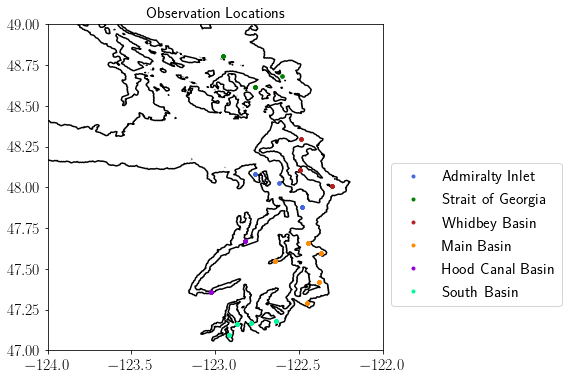

In [13]:
fig, ax = plt.subplots(1,1,figsize = (6,6))
with nc.Dataset('/data/vdo/MEOPAR/NEMO-forcing/grid/bathymetry_201702.nc') as grid:
    viz_tools.plot_coastline(ax, grid, coords = 'map',isobath=.1)
colors=('royalblue','green','firebrick','darkorange','darkviolet','mediumspringgreen',
        'teal','darkgoldenrod','fuchsia','deepskyblue')
datreg=dict()
for ind, iregion in enumerate(data.Basin.unique()):
    datreg[iregion] = data.loc[data.Basin==iregion]
    ax.plot(datreg[iregion]['Lon'], datreg[iregion]['Lat'],'.',
            color = colors[ind], label=iregion)
ax.set_ylim(47, 49)
ax.legend(bbox_to_anchor=[1,.6,0,0])
ax.set_xlim(-124, -122);
ax.set_title('Observation Locations');

iz=(data.Z<15)
JFM=data.loc[iz&(data.dtUTC<=dt.datetime(year,4,1)),:]
Apr=data.loc[iz&(data.dtUTC<=dt.datetime(year,5,1))&(data.dtUTC>dt.datetime(year,4,1)),:]
MJJA=data.loc[iz&(data.dtUTC<=dt.datetime(year,9,1))&(data.dtUTC>dt.datetime(year,5,1)),:]
SOND=data.loc[iz&(data.dtUTC>dt.datetime(year,9,1)),:]

In [14]:
def byDepth(ax,obsvar,modvar,lims):
    ps=et.varvarPlot(ax,data,obsvar,modvar,'Z',(15,22),'z','m',('mediumseagreen','darkturquoise','navy'))
    l=ax.legend(handles=ps)
    ax.set_xlabel('Obs')
    ax.set_ylabel('Model')
    ax.plot(lims,lims,'k-',alpha=.5)
    ax.set_xlim(lims)
    ax.set_ylim(lims)
    ax.set_aspect(1)
    return ps,l

def byRegion(ax,obsvar,modvar,lims):
    ps=[]
    for ind, iregion in enumerate(data.Basin.unique()):
        #ax.plot(datreg[iregion]['Lon'], datreg[iregion]['Lat'],'.',
        #        color = colors[ind], label=iregion)
        ps0=et.varvarPlot(ax,datreg[iregion],obsvar,modvar,
                          cols=(colors[ind],),lname=iregion)
        ps.append(ps0)
    l=ax.legend(handles=[ip[0][0] for ip in ps])
    ax.set_xlabel('Obs')
    ax.set_ylabel('Model')
    ax.plot(lims,lims,'k-',alpha=.5)
    ax.set_xlim(lims)
    ax.set_ylim(lims)
    ax.set_aspect(1)
    return ps,l

def bySeason(ax,obsvar,modvar,lims):
    for axi in ax:
        axi.plot(lims,lims,'k-')
        axi.set_xlim(lims)
        axi.set_ylim(lims)
        axi.set_aspect(1)
        axi.set_xlabel('Obs')
        axi.set_ylabel('Model')
    ps=et.varvarPlot(ax[0],JFM,obsvar,modvar,cols=('crimson','darkturquoise','navy'))
    ax[0].set_title('Jan-Mar')
    ps=et.varvarPlot(ax[1],Apr,obsvar,modvar,cols=('crimson','darkturquoise','navy'))
    ax[1].set_title('Apr')
    ps=et.varvarPlot(ax[2],MJJA,obsvar,modvar,cols=('crimson','darkturquoise','navy'))
    ax[2].set_title('May-Aug')
    ps=et.varvarPlot(ax[3],SOND,obsvar,modvar,cols=('crimson','darkturquoise','navy'))
    ax[3].set_title('Sep-Dec')
    return 

def ErrErr(fig,ax,obsvar1,modvar1,obsvar2,modvar2,lims1,lims2):
    m=ax.scatter(data[modvar1]-data[obsvar1],data[modvar2]-data[obsvar2],c=data['Z'],s=1,cmap='gnuplot')
    cb=fig.colorbar(m,ax=ax,label='Depth (m)')
    ax.set_xlim(lims1)
    ax.set_ylim(lims2)
    ax.set_aspect((lims1[1]-lims1[0])/(lims2[1]-lims2[0]))
    return m,cb

In [15]:
### These groupings will be used to calculate statistics. The keys are labels and
### the values are corresponding dataframe views
statsubs=OrderedDict({'z < 15 m':data.loc[data.Z<15],
                      '15 m < z < 22 m':data.loc[(data.Z>=15)&(data.Z<22)],
                      'z >= 22 m':data.loc[data.Z>=22],
                      'z > 50 m':data.loc[data.Z>50],
                      'all':data,
                      'z < 15 m, JFM':JFM,
                      'z < 15 m, Apr':Apr,
                      'z < 15 m, MJJA':MJJA,
                      'z < 15 m, SOND': SOND,})
for iregion in data.Basin.unique():
    statsubs[iregion]=datreg[iregion]
statsubs.keys()

odict_keys(['z < 15 m', '15 m < z < 22 m', 'z >= 22 m', 'z > 50 m', 'all', 'z < 15 m, JFM', 'z < 15 m, Apr', 'z < 15 m, MJJA', 'z < 15 m, SOND', 'Admiralty Inlet', 'Strait of Georgia', 'Whidbey Basin', 'Main Basin', 'Hood Canal Basin', 'South Basin'])

In [16]:
data=data.sort_values(['Basin'])

# Nitrate

In [17]:
obsvar='NO23'
modvar='mod_nitrate'
statsDict={year:dict()}
statsDict[year]['NO3']=OrderedDict()
for isub in statsubs:
    print(isub)
    statsDict[year]['NO3'][isub]=dict()
    var=statsDict[year]['NO3'][isub]
    var['N'],mmean,omean,var['Bias'],var['RMSE'],var['WSS']=et.stats(statsubs[isub].loc[:,[obsvar]],
                                                                     statsubs[isub].loc[:,[modvar]])
tbl,tdf=et.displayStats(statsDict[year]['NO3'],level='Subset',suborder=list(statsubs.keys()))
tbl

z < 15 m
15 m < z < 22 m
z >= 22 m
z > 50 m
all
z < 15 m, JFM
z < 15 m, Apr
z < 15 m, MJJA
z < 15 m, SOND
Admiralty Inlet
Strait of Georgia
Whidbey Basin
Main Basin
Hood Canal Basin
South Basin


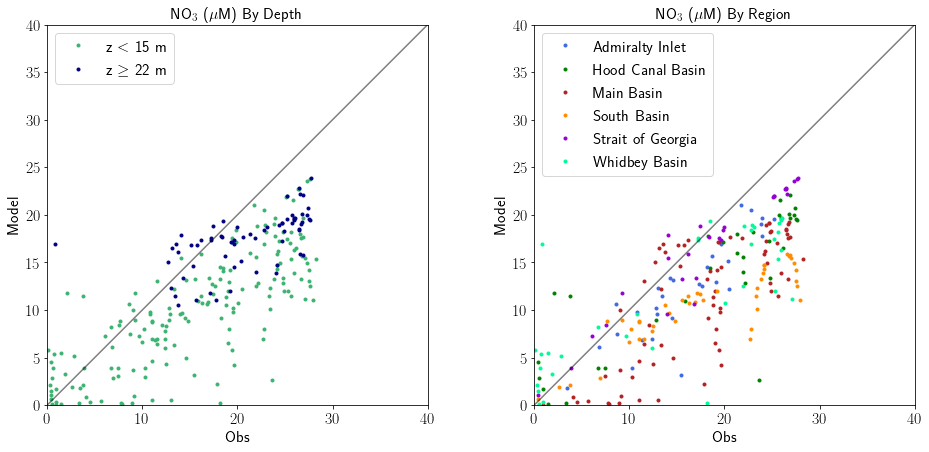

In [18]:
fig, ax = plt.subplots(1,2,figsize = (16,7))
ps,l=byDepth(ax[0],obsvar,modvar,(0,40))
ax[0].set_title('NO$_3$ ($\mu$M) By Depth')

ps,l=byRegion(ax[1],obsvar,modvar,(0,40))
ax[1].set_title('NO$_3$ ($\mu$M) By Region');

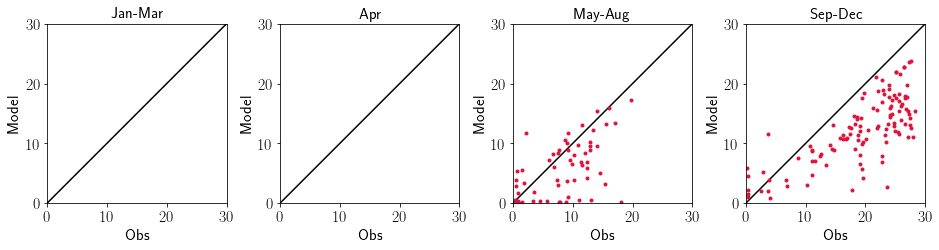

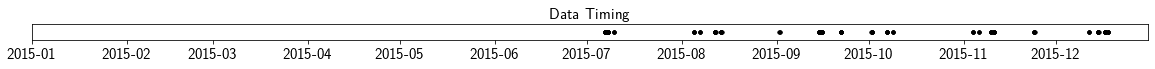

In [19]:
fig, ax = plt.subplots(1,4,figsize = (16,3.3))
bySeason(ax,obsvar,modvar,(0,30))
fig,ax=plt.subplots(1,1,figsize=(20,.3))
ax.plot(data.dtUTC,np.ones(np.shape(data.dtUTC)),'k.')
ax.set_xlim((dt.datetime(year,1,1),dt.datetime(year,12,31)))
ax.set_title('Data Timing')
ax.yaxis.set_visible(False)

# Dissolved Silica

In [20]:
obsvar='Si'
modvar='mod_silicon'
statsDict[year]['dSi']=OrderedDict()
for isub in statsubs:
    statsDict[year]['dSi'][isub]=dict()
    var=statsDict[year]['dSi'][isub]
    var['N'],mmean,omean,var['Bias'],var['RMSE'],var['WSS']=et.stats(statsubs[isub].loc[:,[obsvar]],
                                                                     statsubs[isub].loc[:,[modvar]])
tbl,tdf=et.displayStats(statsDict[year]['dSi'],level='Subset',suborder=list(statsubs.keys()))
tbl

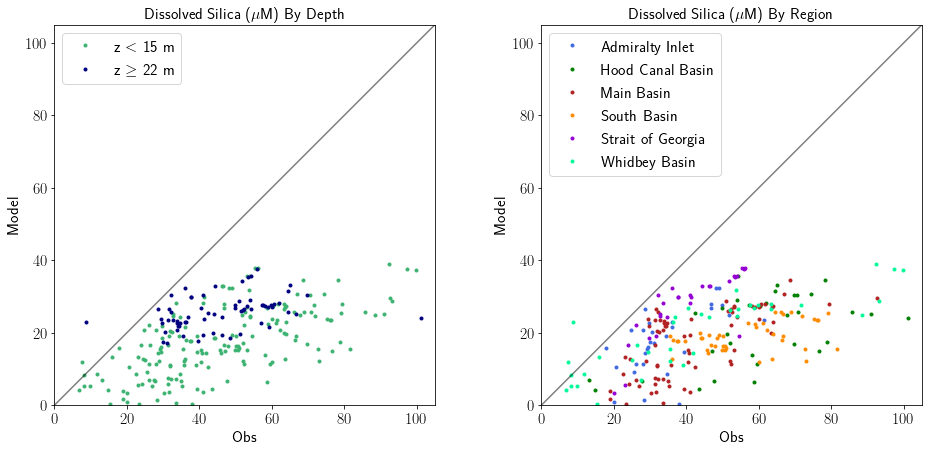

In [21]:
mv=(0,105)
fig, ax = plt.subplots(1,2,figsize = (16,7))
ps,l=byDepth(ax[0],obsvar,modvar,mv)
ax[0].set_title('Dissolved Silica ($\mu$M) By Depth')

ps,l=byRegion(ax[1],obsvar,modvar,mv)
ax[1].set_title('Dissolved Silica ($\mu$M) By Region');

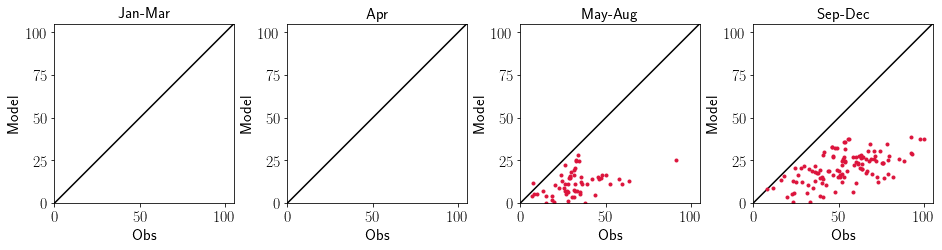

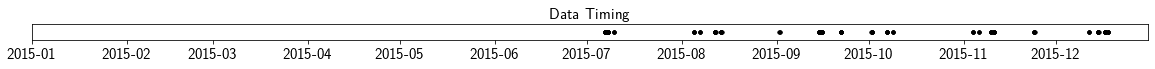

In [22]:
fig, ax = plt.subplots(1,4,figsize = (16,3.3))
bySeason(ax,obsvar,modvar,mv)
fig,ax=plt.subplots(1,1,figsize=(20,.3))
ax.plot(data.dtUTC,np.ones(np.shape(data.dtUTC)),'k.')
ax.set_xlim((dt.datetime(year,1,1),dt.datetime(year,12,31)))
ax.set_title('Data Timing')
ax.yaxis.set_visible(False)

### Profiles of NO3 and Dissolved Silica

Text(0.5, 1.0, 'dSi')

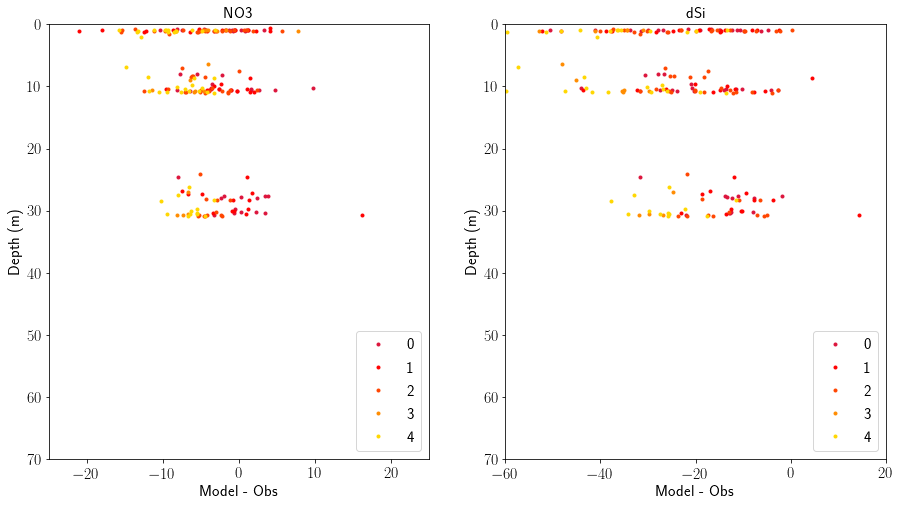

In [23]:
fig, ax = plt.subplots(1,2,figsize = (15,8))
cols=('crimson','red','orangered','darkorange','gold','chartreuse','green','lightseagreen','cyan',
      'darkturquoise','royalblue','lightskyblue','blue','darkblue','mediumslateblue','blueviolet',
      'darkmagenta','fuchsia','deeppink','pink')
ii0=start_date
for ii in range(0,int((end_date-start_date).days/30)):
    iii=(data.dtUTC>=(start_date+dt.timedelta(days=ii*30)))&(data.dtUTC<(start_date+dt.timedelta(days=(ii+1)*30)))
    ax[0].plot(data.loc[iii,['mod_nitrate']].values-data.loc[iii,['NO23']].values, data.loc[iii,['Z']].values, 
        '.', color = cols[ii],label=str(ii))
    ax[1].plot(data.loc[iii,['mod_silicon']].values-data.loc[iii,['Si']].values, data.loc[iii,['Z']].values, 
        '.', color = cols[ii],label=str(ii))
for axi in (ax[0],ax[1]):
    axi.legend(loc=4)
    axi.set_ylim(70,0)
    axi.set_ylabel('Depth (m)')
ax[0].set_xlabel('Model - Obs')
ax[1].set_xlabel('Model - Obs')
ax[0].set_xlim(-25,25)
ax[1].set_xlim(-60,20)
ax[0].set_title('NO3')
ax[1].set_title('dSi')

# dSi:NO3 Ratios

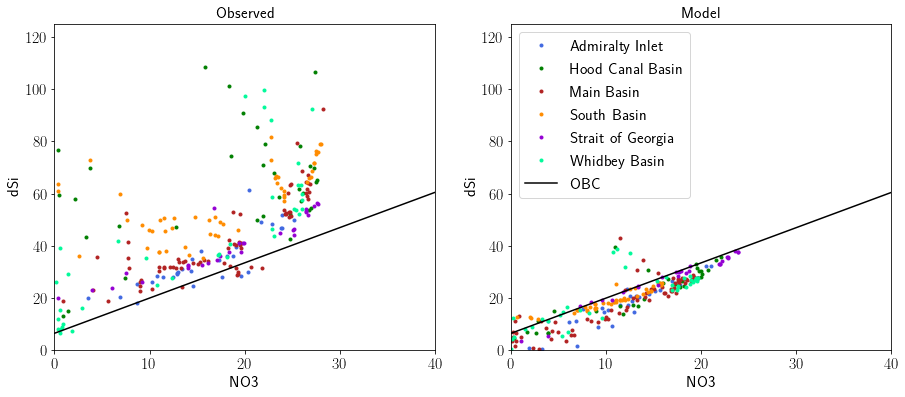

In [24]:
fig,ax=plt.subplots(1,2,figsize=(15,6))
for ind,iregion in enumerate(data.Basin.unique()):
    p1=ax[0].plot(datreg[iregion]['NO23'],datreg[iregion]['Si'],'.',
                  color=colors[ind],label=iregion)
ax[0].plot(np.arange(0,41),1.35*np.arange(0,41)+6.46,'k-',label='OBC')
ax[0].set_title('Observed')
ax[0].set_xlabel('NO3')
ax[0].set_ylabel('dSi')
ax[0].set_xlim(0,40)
ax[0].set_ylim(0,125)
#ax[0].legend()

for ind,iregion in enumerate(data.Basin.unique()):
    p=ax[1].plot(datreg[iregion]['mod_nitrate'],datreg[iregion]['mod_silicon'],'.',
                  color=colors[ind],label=iregion)
ax[1].plot(np.arange(0,41),1.35*np.arange(0,41)+6.46,'k-',label='OBC')
ax[1].set_title('Model')
ax[1].set_xlabel('NO3')
ax[1].set_ylabel('dSi')
ax[1].set_xlim(0,40)
ax[1].set_ylim(0,125)
ax[1].legend()
#ax[0].plot(np.arange(0,35),1.3*np.arange(0,35),'k-')
#ax[1].plot(np.arange(0,35),1.3*np.arange(0,35),'k-')

# NH4

In [25]:
obsvar='Amm'
modvar='mod_ammonium'
statsDict[year]['NH4']=OrderedDict()
for isub in statsubs:
    statsDict[year]['NH4'][isub]=dict()
    var=statsDict[year]['NH4'][isub]
    var['N'],mmean,omean,var['Bias'],var['RMSE'],var['WSS']=et.stats(statsubs[isub].loc[:,[obsvar]],
                                                                     statsubs[isub].loc[:,[modvar]])
tbl,tdf=et.displayStats(statsDict[year]['NH4'],level='Subset',suborder=list(statsubs.keys()))
tbl

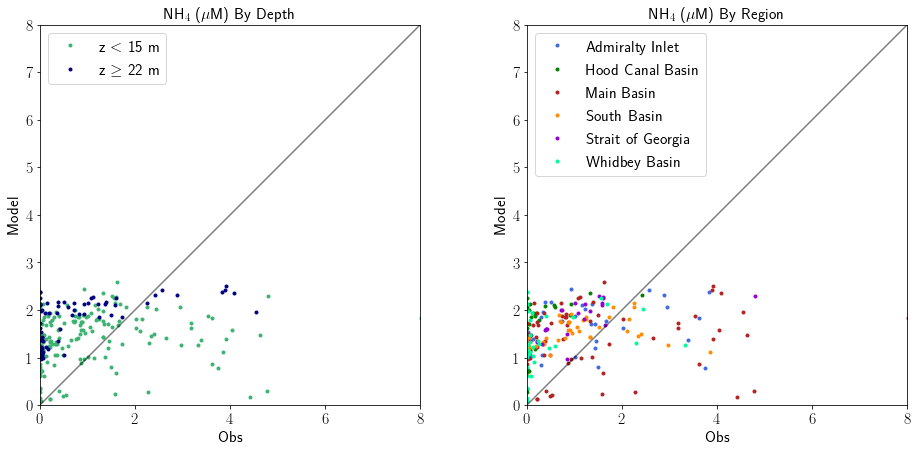

In [26]:
fig, ax = plt.subplots(1,2,figsize = (16,7))
ps,l=byDepth(ax[0],obsvar,modvar,(0,8))
ax[0].set_title('NH$_4$ ($\mu$M) By Depth')

ps,l=byRegion(ax[1],obsvar,modvar,(0,8))
ax[1].set_title('NH$_4$ ($\mu$M) By Region');

In [27]:
len(data)

256

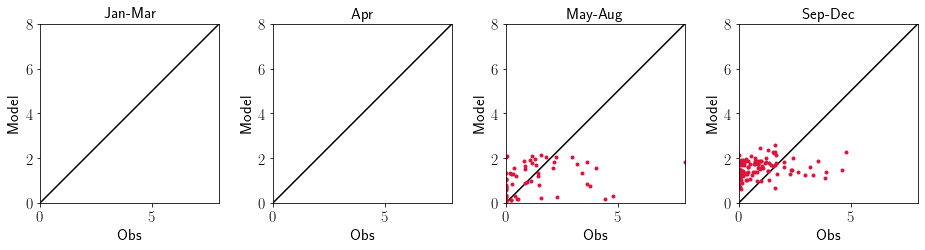

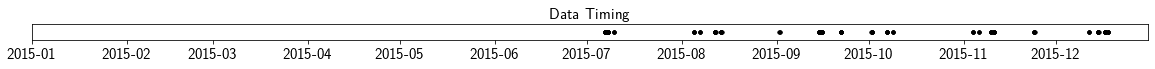

In [28]:
fig, ax = plt.subplots(1,4,figsize = (16,3.3))
bySeason(ax,obsvar,modvar,(0,8))
fig,ax=plt.subplots(1,1,figsize=(20,.3))
ax.plot(data.dtUTC,np.ones(np.shape(data.dtUTC)),'k.')
ax.set_xlim((dt.datetime(year,1,1),dt.datetime(year,12,31)))
ax.set_title('Data Timing')
ax.yaxis.set_visible(False)

## Error vs salinity

Text(0, 0.5, 'NH4 Error ($\\mu$M) Error')

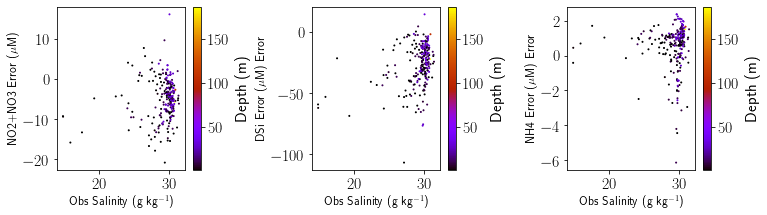

In [29]:
fig,ax=plt.subplots(1,3,figsize=(12,3))
fig.subplots_adjust(wspace=.6)
m=ax[0].scatter(data['SA'],data['mod_nitrate']-data['NO23'],c=data['Z'],s=1,cmap='gnuplot')
cb=fig.colorbar(m,ax=ax[0],label='Depth (m)')
ax[0].set_xlabel('Obs Salinity (g kg$^{-1}$)',fontsize=12)
ax[0].set_ylabel('NO2+NO3 Error ($\mu$M)',fontsize=12)

m=ax[1].scatter(data['SA'],data['mod_silicon']-data['Si'],c=data['Z'],s=1,cmap='gnuplot')
cb=fig.colorbar(m,ax=ax[1],label='Depth (m)')
ax[1].set_xlabel('Obs Salinity (g kg$^{-1}$)',fontsize=12)
ax[1].set_ylabel('DSi Error ($\mu$M) Error',fontsize=12)

m=ax[2].scatter(data['SA'],data['mod_ammonium']-data['Amm'],c=data['Z'],s=1,cmap='gnuplot')
cb=fig.colorbar(m,ax=ax[2],label='Depth (m)')
ax[2].set_xlabel('Obs Salinity (g kg$^{-1}$)',fontsize=12)
ax[2].set_ylabel('NH4 Error ($\mu$M) Error',fontsize=12)

## Error vs salinity error

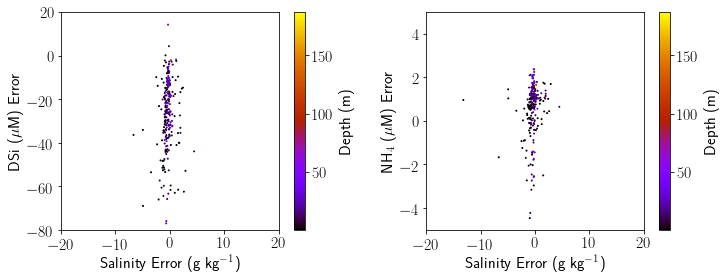

In [30]:
fig,ax=plt.subplots(1,2,figsize=(12,4))
ax[0].set_xlabel('Salinity Error (g kg$^{-1}$)')
ax[0].set_ylabel('DSi ($\mu$M) Error')
m,cb=ErrErr(fig,ax[0],'SA','mod_vosaline','Si','mod_silicon',(-20,20),(-80,20))
ax[1].set_xlabel('Salinity Error (g kg$^{-1}$)')
ax[1].set_ylabel('NH$_4$ ($\mu$M) Error')
m,cb=ErrErr(fig,ax[1],'SA','mod_vosaline','Amm','mod_ammonium',(-20,20),(-5,5))

## N vs Sal

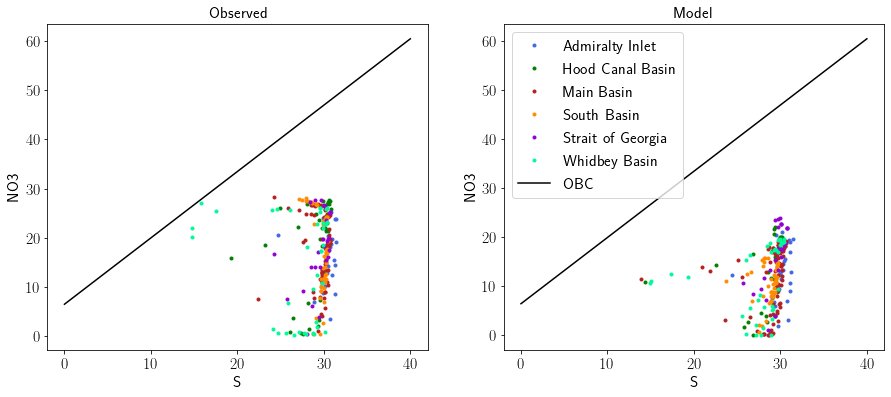

In [31]:
fig,ax=plt.subplots(1,2,figsize=(15,6))
for ind,iregion in enumerate(data.Basin.unique()):
    p1=ax[0].plot(datreg[iregion]['SA'],datreg[iregion]['NO23'],'.',
                  color=colors[ind],label=iregion)
ax[0].plot(np.arange(0,41),1.35*np.arange(0,41)+6.46,'k-',label='OBC')
ax[0].set_title('Observed')
ax[0].set_xlabel('S')
ax[0].set_ylabel('NO3')
#ax[0].set_xlim(0,40)
#ax[0].set_ylim(0,125)
#ax[0].legend()

for ind,iregion in enumerate(data.Basin.unique()):
    p=ax[1].plot(datreg[iregion]['mod_vosaline'],datreg[iregion]['mod_nitrate'],'.',
                  color=colors[ind],label=iregion)
ax[1].plot(np.arange(0,41),1.35*np.arange(0,41)+6.46,'k-',label='OBC')
ax[1].set_title('Model')
ax[1].set_xlabel('S')
ax[1].set_ylabel('NO3')
#ax[1].set_xlim(0,40)
#ax[1].set_ylim(0,125)
ax[1].legend()

## Error vs lat

Text(0, 0.5, 'NH4 Error ($\\mu$M) Error')

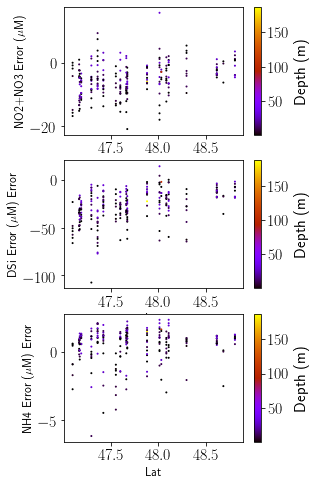

In [32]:
fig,ax=plt.subplots(3,1,figsize=(4,8))
fig.subplots_adjust(wspace=.6)
m=ax[0].scatter(data['Lat'],data['mod_nitrate']-data['NO23'],c=data['Z'],s=1,cmap='gnuplot')
cb=fig.colorbar(m,ax=ax[0],label='Depth (m)')
ax[0].set_xlabel('Lat',fontsize=12)
ax[0].set_ylabel('NO2+NO3 Error ($\mu$M)',fontsize=12)

m=ax[1].scatter(data['Lat'],data['mod_silicon']-data['Si'],c=data['Z'],s=1,cmap='gnuplot')
cb=fig.colorbar(m,ax=ax[1],label='Depth (m)')
ax[1].set_xlabel('Lat',fontsize=12)
ax[1].set_ylabel('DSi Error ($\mu$M) Error',fontsize=12)

m=ax[2].scatter(data['Lat'],data['mod_ammonium']-data['Amm'],c=data['Z'],s=1,cmap='gnuplot')
cb=fig.colorbar(m,ax=ax[2],label='Depth (m)')
ax[2].set_xlabel('Lat',fontsize=12)
ax[2].set_ylabel('NH4 Error ($\mu$M) Error',fontsize=12)

In [33]:
tbl,tdf=et.displayStats(statsDict[year],level='Variable',suborder=list(statsubs.keys()))
tbl